In [1]:
import yfinance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras


from datetime import timedelta, date
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
ticker = yfinance.Ticker('ETH-USD')
df = ticker.history(start = "2017-11-9", end = "2023-5-4", interval = "1d")

df['arithmetic_return'] = df.Close.pct_change().dropna()*100
df['logarithmic_return'] = np.log(df.Close/df.Close.shift(1))

def r_vol(r_vol_log):
    n = len(r_vol_log)
    return np.sqrt(np.sum(r_vol_log**2)/(n - 1))

week = 7
rolling_vol = 168

df['week_forward'] = df.logarithmic_return.shift(- week)\
                                 .rolling(window = rolling_vol)\
                                 .apply(r_vol)

df['rolling_vol'] = df.logarithmic_return.rolling(window = rolling_vol)\
                                   .apply(r_vol)

df = df.drop(['Dividends', 'Stock Splits'], axis = 1)
df.dropna(inplace = True)
df.describe()

def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def rnn_matrix(x_data, y_data, interval):
    rnn_input, rnn_output = [], []
    for i in range((interval - 1), len(x_data)):
        begin = x_data.index[i - interval + 1]
        finish = x_data.index[i]
        x_val = x_data[begin:finish].values
        y_val = y_data[finish]
        rnn_input.append(x_val)
        rnn_output.append(y_val)
    return np.array(rnn_input), np.array(rnn_output)

testing_batch = 294
validation_batch = 294

test_val_batch_index = len(df) - (testing_batch + validation_batch)
test_batch_index = len(df) - testing_batch
training_index = df.index[:test_val_batch_index]
testing_index = df.index[test_batch_index:]
y_test = df.week_forward[testing_index]

df['high-low'] = np.log((df.High - df.Low) / df.Close)
df['close-open'] = (df.Close - df.Open) / df.Open
df['volume'] = np.log(df.Volume)
df.describe(include = 'all')

columns = ['high-low', 'close-open', 'volume', 'rolling_vol']
input_df = df[columns]
partitions_df = input_df[:test_batch_index]
partitions_y = df.week_forward[:test_batch_index]
rx_train = input_df.loc[training_index]

def time_series_prediction(model, partition_index):
    begin = partition_index[0] - timedelta(days = n_past - 1)
    finish = partition_index[-1]
    input_data, _ = rnn_matrix(input_df[begin:finish], 
                                df.week_forward[partition_index], n_past)
    return pd.Series(model.predict(input_data)[:, 0],
                      index = partition_index)

In [8]:
tf.keras.backend.clear_session()
seed = 42
np.random.seed(seed)

n_past = 30
batch_size = 64
n_features = input_df.shape[1]

rnn_X_partitions, rnn_y_partitions = rnn_matrix(partitions_df, partitions_y, n_past)

# multivariate 3 layer lstm neural network
lstm = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_features]),
    tf.keras.layers.BatchNormalization(), 
    
    # layer number 1
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.08),

    # layer number 2
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.08),

    # layer number 3
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.08),
    
    # output layer
    tf.keras.layers.Dense(1)
])

lstm.compile(loss = 'mse', metrics = [rmspe])
checkpoint_cb = ModelCheckpoint('lstm.h5', save_best_only = True, monitor = 'val_rmspe')

# finish training if no more improvements on rmspe
early_stopping_cb = EarlyStopping(patience = 30, restore_best_weights = True, monitor = 'val_rmspe')
print(lstm.summary())

gpu = len(tf.config.list_physical_devices('GPU'))>0
lstm_display = lstm.fit(rnn_X_partitions, rnn_y_partitions, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

y_testing_prediction = time_series_prediction(lstm, testing_index)
rnn_X_bucket, _ = rnn_matrix(input_df, df.week_forward, n_past)
prediction_bucket = pd.Series(lstm.predict(rnn_X_bucket)[:,0], 
                      index=df.index[-(rnn_X_bucket).shape[0]:])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          35328     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

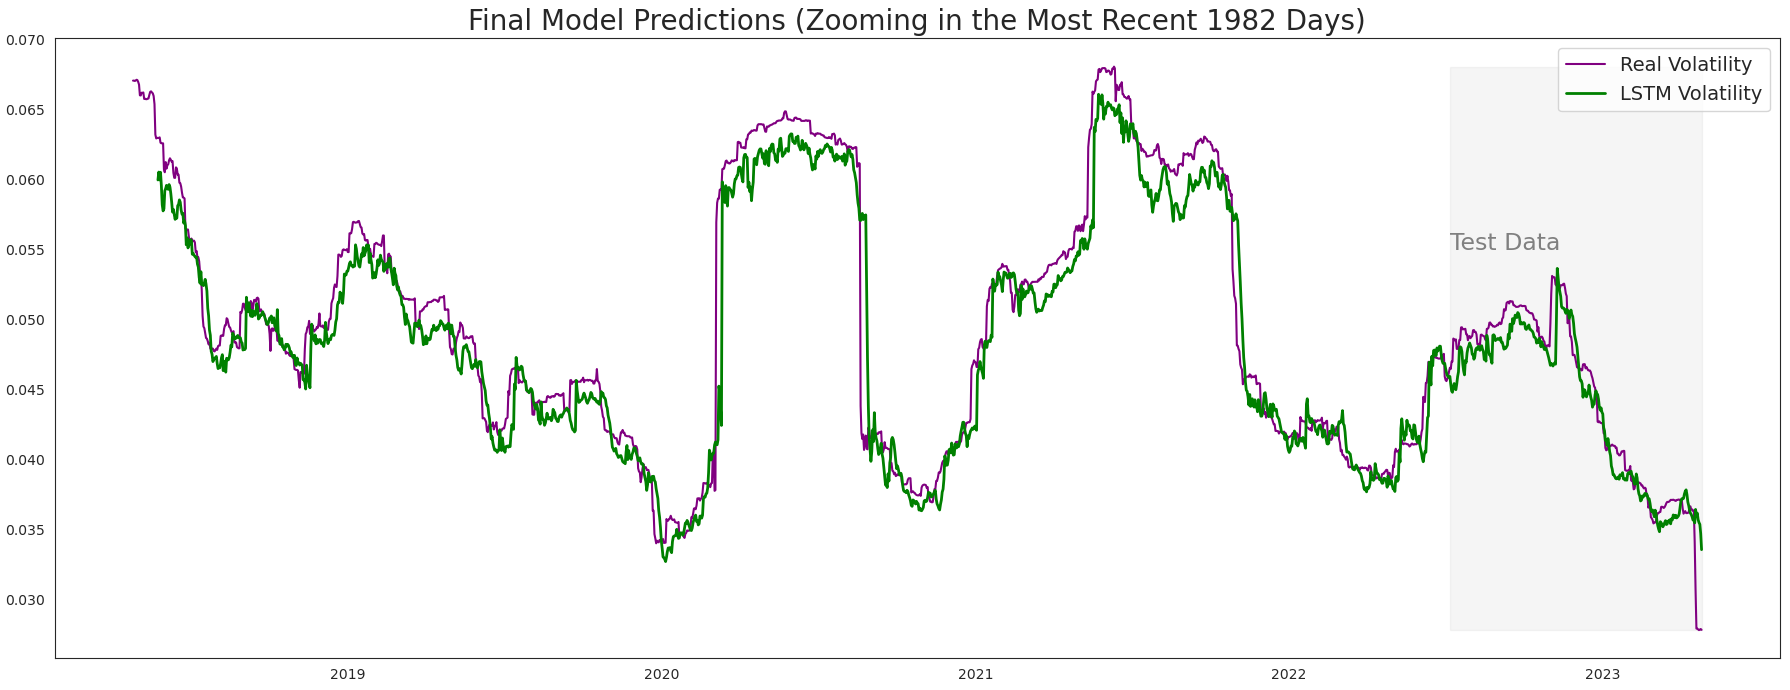

In [9]:
# lstm model displayed with forecasted and expected targets
with sns.axes_style("white"):
    n_display = 1982
    fig, ax = plt.subplots(figsize = (18, 7))
    
    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax.plot(df.week_forward[-n_display:], color = 'purple', label = f"Real Volatility")
    ax.plot(prediction_bucket[-n_display:], color = 'green', lw = 2, label = f'LSTM Volatility')
    ax.text(df.index[(test_batch_index)], 0.055, 'Test Data', fontsize = 17, color = 'grey')
    
    # tested data zone   
    width = len(testing_index) - 1 
    height = df.week_forward[-n_display:].max() - df.week_forward[-n_display:].min()
    x = mdates.date2num(df.index[test_batch_index])
    y = df.week_forward[-n_display:].min()
    rectangle = Rectangle((x, y), width, height, color = 'grey', alpha = 0.075)
    ax.add_patch(rectangle)
    
    ax.legend(loc='upper right', prop={'size': 14})
    plt.tight_layout()

In [10]:
print(df.head())

                                 Open        High         Low       Close   
Date                                                                        
2018-04-26 00:00:00+00:00  618.078979  663.181030  604.007019  662.809021  \
2018-04-27 00:00:00+00:00  662.109009  684.867981  647.031982  647.031982   
2018-04-28 00:00:00+00:00  644.645996  691.442017  644.645996  683.677979   
2018-04-29 00:00:00+00:00  683.911987  697.755981  670.513000  688.880981   
2018-04-30 00:00:00+00:00  689.760986  694.439026  666.117004  669.924011   

                               Volume  arithmetic_return  logarithmic_return   
Date                                                                           
2018-04-26 00:00:00+00:00  2984009984           7.700970            0.074188  \
2018-04-27 00:00:00+00:00  2598129920          -2.380329           -0.024091   
2018-04-28 00:00:00+00:00  2496659968           5.663707            0.055091   
2018-04-29 00:00:00+00:00  2740559872           0.761031    

In [11]:
# Create a new DataFrame combining 'week_forward' and 'prediction_bucket'
combined_df = pd.DataFrame({'week_forward': df['week_forward'], 'prediction_bucket': prediction_bucket})

# Drop rows with missing values (if any)
combined_df.dropna(inplace=True)

# Get the latest 30 values
latest_30_values = combined_df.tail(30)

# Export the DataFrame to a JSON file
latest_30_values.to_json(r'C:\Users\main\Desktop\export_latest_30_values.json')
